In [111]:
import pandas as pd
import time
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords
from groq import Groq
import os
from dotenv import load_dotenv
from nltk.tokenize import sent_tokenize
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskarroeske/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
df_evaluation = pd.read_csv("evaluation_sentences.csv")

In [113]:
list_of_arguments = [
    "Earnings per Share",
    "Cash Flow",
    "Revenue",
    "Return on Equity",
    "Margins",
    "Cost Management",
    "Dividend Policy",
    "Investments",
    "Balance Sheet",
    "Long-term Growth",
    "Mergers and Acquisition",
    "Refranchising",
    "Sustainability",
    "Employees",
    "Research and Development",
    "Marketing",
    "Shares Repurchase",
    "Processes",
    "Leadership",
    "Innovation",
    "Product Characteristics",
    "Pricing Strategy",
    "Production",
    "Technology Trends",
    "Market Share",
    "Market Expansion",
    "Competitors",
    "Global Presence",
    "Industry Outlook",
    "Regulations",
    "Partnerships and Collaborations",
    "Supply Chain",
    "Economic Conditions",
    "Demand",
    "Customers"
]


In [114]:
#list_of_arguments = ["Financial Performance","Revenue Growth"]
# paragraph removed from instructions: - New categories must be generic, concise (max 3 words), and included in the output for list updates.
"""You will classify financial text into predefined categories or create a new one if needed:
- Assign arguments to the best-matching category. Create a new category only if no match fits.
- IGNORE brand names/Target Prices/Recommendations/Valuation as arguments.
- Classify each argument as positive, negative, or neutral.
- Include new categories in the output.
- Return only the JSON dictionary, no extra text.

In system_content: Categories: [{categories_string}]
"""


def find_arguments(text, api_key):
    client = Groq(api_key=api_key)

    categories_string = ', '.join(f'"{cat}"' for cat in list_of_arguments)

    system_content = f"""You will classify financial sentences into predefined categories or create a new one if needed:
- Assign arguments to the best-matching category. Create a new category only if no match fits.
- IGNORE brand names/Target Prices/Recommendations/Valuation as arguments.
- If no meaningful argument is mentioned in the text, return "None"
- Include new categories in the output.
- Return only the best-fitting category as a String
- Print only the result! No other text!
Categories: [{categories_string}]
"""
    final_prompt = f"""
        Text: {text}
       """
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_content,
            },
            {
                "role": "user",
                "content": final_prompt,
            }
        ],
        temperature=0,
        model="llama-3.3-70b-versatile",
    )

    return response.choices[0].message.content

In [115]:
import json
from itertools import cycle

# Load API key
load_dotenv()

api_key = os.getenv("GROQ_API_KEY")

def extract_arguments_and_sentiment(commentary):
    global list_of_arguments  # Ensure we can modify the global categories list
    result = None
    
    # Call the find_arguments function with the selected API key
    result_json = find_arguments(commentary, api_key)   
        
    # Check for new categories and add them to the global list
    if result_json not in list_of_arguments:
        list_of_arguments.append(result_json)  # Dynamically update the categories list
                
    time.sleep(4)
    if result_json is not None:
        result = result_json
    return result

In [116]:
keywords_dict = {
    "Financial Performance": {
        "Earnings per Share": [],
        "Cash Flow":[],
        "Revenue": [],
        "Return on Equity": [],
        "Margins": [],
        "Cost Management": [],
        "Dividend Policy": [],
        "Investments": [],
        "Balance Sheet": [],
    },
    "Company": {
        "Long-term Growth": [],
        "Mergers and Acquisition": [],
        "Refranchising": [],
        "Sustainability": [],
        "Employees": [],
        "Research and Development":[],
        "Marketing":[],
        "Shares Repurchase": [],
        "Processes":[],
        "Leadership":[],
    },
    "Product": {
        "Innovation": [],
        "Product Characteristics":[],
        "Pricing Strategy":[],
        "Production": [],
        "Technology Trends":[]
    },
    "Market": {
        "Market Share": [],
        "Market Expansion": [],
        "Competitors":[],
        "Global Presence": [],
        "Industry Outlook":[],
		"Regulations":[],
        "Partnerships and Collaborations":[],
        "Supply Chain":[],
        "Economic Conditions": [],
        "Demand":[],
        "Customers": []
    }
}


In [117]:
df_evaluation["predicted_arguments"] = df_evaluation["Sentence"].apply(extract_arguments_and_sentiment)

# Sentiment

In [118]:
"""TP_sentiment = 0
FP_sentiment = 0

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual_sentiment, predicted_sentiment = row["Sentiment"].lower(), row["predicted_sentiment"].lower()
    if actual_sentiment == predicted_sentiment:
        TP_sentiment += 1  # Correct argument assigned
    else:
        FP_sentiment += 1


# Calculate precision_category, recall_category, and F1_category score
accuracy_sentiment = TP_sentiment / (TP_sentiment + FP_sentiment)

print(f"TP_sentiment: {TP_sentiment}")
print(f"FP_sentiment: {FP_sentiment}")
print(f"accuracy_sentiment: {accuracy_sentiment}")"""

'TP_sentiment = 0\nFP_sentiment = 0\n\n# Evaluate each row\nfor index, row in df_evaluation.iterrows():\n    actual_sentiment, predicted_sentiment = row["Sentiment"].lower(), row["predicted_sentiment"].lower()\n    if actual_sentiment == predicted_sentiment:\n        TP_sentiment += 1  # Correct argument assigned\n    else:\n        FP_sentiment += 1\n\n\n# Calculate precision_category, recall_category, and F1_category score\naccuracy_sentiment = TP_sentiment / (TP_sentiment + FP_sentiment)\n\nprint(f"TP_sentiment: {TP_sentiment}")\nprint(f"FP_sentiment: {FP_sentiment}")\nprint(f"accuracy_sentiment: {accuracy_sentiment}")'

In [119]:
"""df_evaluation.to_csv("llama_sentiment_testing.csv")"""

'df_evaluation.to_csv("llama_sentiment_testing.csv")'

# Argument Level

In [124]:
# Initialize counts
TP = 0  # True Positive
FP = 0  # False Positive (Wrong argument assigned)
FP2 = 0 # False positive (no argument should have been assigned)
FN = 0  # False Negative
TN = 0  # True Negative

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual, predicted = row["Label"], row["predicted_arguments"]
    if actual == predicted and not pd.isna(actual):
        TP += 1  # Correct argument assigned
    elif pd.isna(actual) and predicted == "None":
        TN += 1  #no actual argument and none assigned
    elif not pd.isna(actual) and predicted == "None":
        FN += 1  # No argument was assigned
    elif actual != predicted and pd.isna(actual):
        FP2 += 1  # Argument assigned when no should be
    elif actual != predicted:
        FP += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Positives 2 (FP): {FP2}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

FP = FP + FP2

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

True Positives (TP): 70
False Positives (FP): 52
False Positives 2 (FP): 10
False Negatives (FN): 2
True Negatives (TN): 16
Precision: 0.5303030303030303
Recall: 0.9722222222222222
F1 Score: 0.6862745098039216


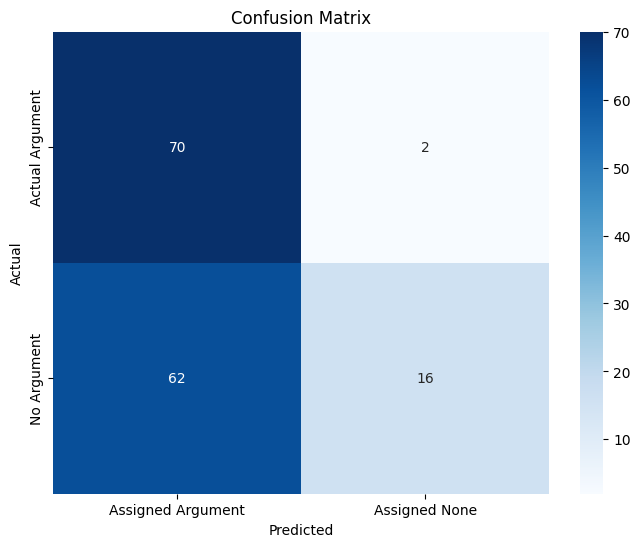

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns  

# Data for the confusion matrix
confusion_data = {
    "Assigned Argument": [TP, FP],  
    "Assigned None": [FN, TN]  
}

confusion_matrix = pd.DataFrame(
    confusion_data, 
    index=["Actual Argument", "No Argument"]
)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Category Level

In [125]:
reverse_mapping = {}
for overall_category, subcategories in keywords_dict.items():
    for subcategory in subcategories:
        reverse_mapping[subcategory] = overall_category

def get_overall_category(subcategory):
    return reverse_mapping.get(subcategory, "Unknown Category")


df_evaluation["actual_category"] = df_evaluation["Label"].apply(get_overall_category)
df_evaluation["predicted_category"] = df_evaluation["predicted_arguments"].apply(get_overall_category)


True Positives (TP): 94
False Positives (FP): 26
False Positives 2 (FP): 11
False Negatives (FN): 3
True Negatives (TN): 16
Precision_category: 0.7175572519083969
Recall_category: 0.9690721649484536
F1_category Score: 0.8245614035087719


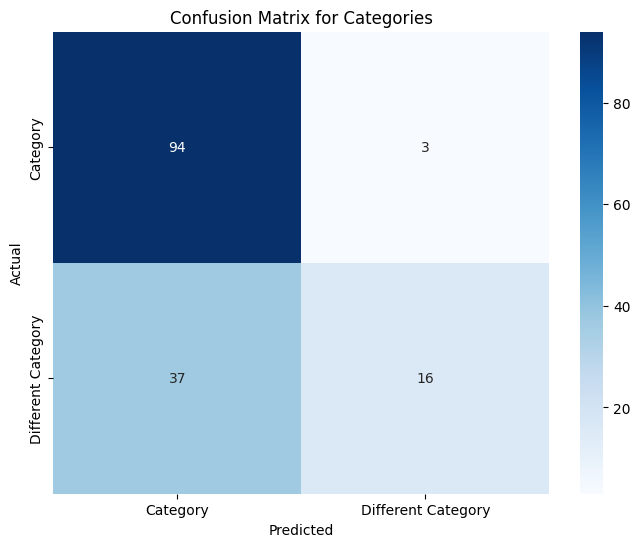

In [126]:

# Initialize counts
TP_category = 0  # True Positive
FP_category = 0  # False Positive (Wrong category assigned)
FP_category2 = 0 # False positive (no category should have been assigned)
FN_category = 0  # False Negative
TN_category = 0  # True Negative

for index, row in df_evaluation.iterrows():
    actual_category, predicted_category = row["actual_category"], row["predicted_category"]
    if actual_category == predicted_category and actual_category != "Unknown Category":
        TP_category += 1  # Correct argument assigned
    elif  actual_category == "Unknown Category" and predicted_category == "Unknown Category":
        TN_category += 1  # No cateogry was given and none was predicted
    elif actual_category != "Unknown Category" and predicted_category == "Unknown Category":
        FN_category += 1  # No argument was assigned
    elif actual_category != predicted_category and actual_category == "Unknown Category":
        FP_category2 += 1  # Argument assigned when no should be
    elif actual_category != predicted_category:
        FP_category += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP_category}")
print(f"False Positives (FP): {FP_category}")
print(f"False Positives 2 (FP): {FP_category2}")
print(f"False Negatives (FN): {FN_category}")
print(f"True Negatives (TN): {TN_category}")


FP_category = FP_category + FP_category2

# Calculate precision_category, recall_category, and F1_category score
precision_category = TP_category / (TP_category + FP_category) if (TP_category + FP_category) > 0 else 0
recall_category = TP_category / (TP_category + FN_category) if (TP_category + FN_category) > 0 else 0
f1_category = 2 * (precision_category * recall_category) / (precision_category + recall_category) if (precision_category + recall_category) > 0 else 0

print(f"Precision_category: {precision_category}")
print(f"Recall_category: {recall_category}")
print(f"F1_category Score: {f1_category}")


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Confusion matrix data
confusion_data_category = {
    "Category": [TP_category, FP_category],
    "Different Category": [FN_category, TN_category]    
}

# create confusion matrix
confusion_matrix_category = pd.DataFrame(
    confusion_data_category, 
    index=["Category", "Different Category"]  # Row labels
)

#Create heat map
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_category, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Categories")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
